## Importing libraries

In [1]:
import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt
import os

## Helper functions and classes

We create a dense neural network module with a leaky ReLU activation function. We can specify the number of nodes in each layer later.

In [2]:
class MLP(nn.Module):
  def __init__(self, layers):
    super().__init__()
    
    linear_modules = [nn.Linear(x,y) for x,y in zip(layers[:-1], layers[1:])]
    self.layers = nn.ModuleList(linear_modules)
  
  def forward(self, x):
    activation = nn.LeakyReLU()
    for layer in self.layers:
      x = activation(layer(x))
    
    return x

We train the model until it reaches an MSE of $0.01$ or less. If it does not reach this threshold after some pre-determined maximum number of epochs, we stop training.

Accuracy is calculated by rounding the predictions to the nearest integer and comparing it with the correct answer.

In [3]:
def train(model, dataX, dataY, max_epochs, learning_rate, verbose=True):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  mse = float('inf')
  epoch = 0
  while mse > 0.01 and epoch < max_epochs:
    outputs = model.forward(dataX)
    optimizer.zero_grad()
    loss = criterion(outputs, dataY)
    loss.backward()
    optimizer.step()
    
    if verbose or epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
    epoch += 1
    mse = loss.item()
  
  return epoch, mse

def test(model, dataX, dataY):
  model.eval()
  predictions = model(dataX)

  dataY = dataY.numpy().astype(int)
  predictions = (predictions.detach().numpy()+0.5).astype(int)
  
  acc = 0
  for x,y in zip(predictions, dataY):
    acc += all(x == y)
  acc /= len(dataX)

  return acc

We keep track of the number of epochs it took to train the neural network, its final MSE, and its final accuracy.

In [4]:
def run(N, dir, layers, max_epoch, learning_rate, verbose=True):
  df = pd.read_csv(f"data/{dir}/perm{N}.csv")
  dataX = torch.Tensor(df.iloc[:,:N].values)
  dataY = torch.Tensor(df.iloc[:,N:].values)

  model = MLP([N]+layers+[N])
  epoch, train_mse = train(model, dataX, dataY, max_epoch, learning_rate, verbose)
  acc = test(model, dataX, dataY)

  return epoch, train_mse, acc

## Testing Proper

We declare some hyperparameters, and train a DNN with there hyperparameters.

In [6]:
N = 7                                        # Trains all sizes for 4 to N inclusive
TO_TRAIN = ["2swap", "nswap", "3swap"]       # List of bounds to train
LAYERS = [100, 100, 100]                     # Number of nodes in the hidden layers of the DNN
MAX_EPOCH = 10000                            # Maximum number of epochs before training stops immediately
LEARNING_RATE = 0.01                         # DNN learning rate

RESULTS = []                                 # Stores results

In [7]:
for i,dir in enumerate(TO_TRAIN):
  tmp_results = []
  for n in range(4,N+1):
    epoch, train_mse, acc = run(n, dir, LAYERS, MAX_EPOCH, LEARNING_RATE, False)
    tmp_results.append((n, epoch, train_mse, acc))
    print(f"{dir} - Size: {n}, epochs: {epoch},  MSE: {train_mse:.4f}, accuracy: {acc:.4f}")
  RESULTS.append(tmp_results)
  

Epoch: 0, loss: 7.01290
2swap - Size: 4, epochs: 66,  MSE: 0.0097, accuracy: 1.0000
Epoch: 0, loss: 10.02962
Epoch: 100, loss: 0.01562
2swap - Size: 5, epochs: 113,  MSE: 0.0096, accuracy: 0.9916
Epoch: 0, loss: 14.81859
Epoch: 100, loss: 0.07693
Epoch: 200, loss: 0.01515
2swap - Size: 6, epochs: 251,  MSE: 0.0099, accuracy: 0.9930
Epoch: 0, loss: 19.42591
Epoch: 100, loss: 0.35511
Epoch: 200, loss: 0.05127
Epoch: 300, loss: 0.02595
Epoch: 400, loss: 0.01414
Epoch: 500, loss: 0.01015
2swap - Size: 7, epochs: 502,  MSE: 0.0099, accuracy: 0.9897
Epoch: 0, loss: 7.35540
nswap - Size: 4, epochs: 97,  MSE: 0.0084, accuracy: 1.0000
Epoch: 0, loss: 10.30977
Epoch: 100, loss: 0.02945
nswap - Size: 5, epochs: 138,  MSE: 0.0089, accuracy: 0.9748
Epoch: 0, loss: 14.97431
Epoch: 100, loss: 0.23599
Epoch: 200, loss: 0.04913
Epoch: 300, loss: 0.02350
Epoch: 400, loss: 0.01464
nswap - Size: 6, epochs: 489,  MSE: 0.0099, accuracy: 0.9819
Epoch: 0, loss: 19.79125
Epoch: 100, loss: 0.58367
Epoch: 200, l

We can visualize our results for clearer insights.

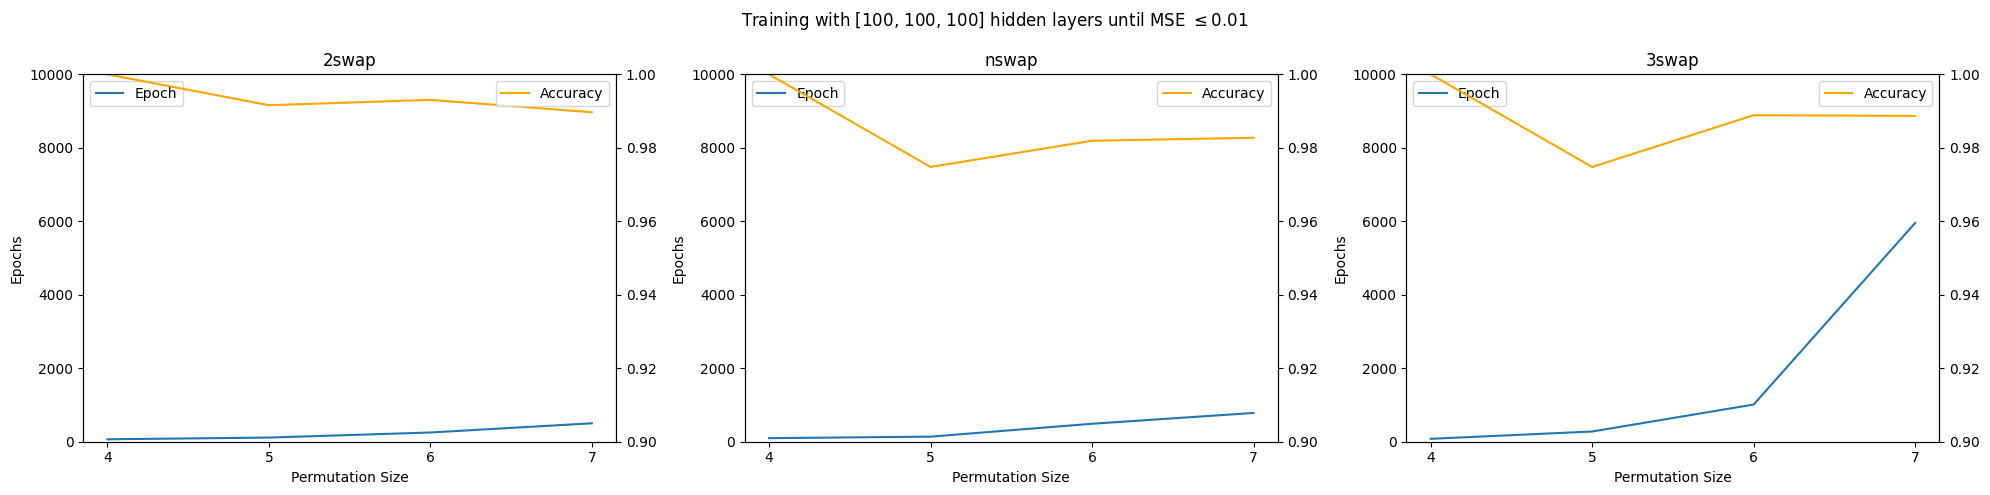

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
for i,ax in enumerate(axes.flatten()[:len(TO_TRAIN)]):
  ax.plot(range(4,N+1), [x[1] for x in RESULTS[i]], label="Epoch")
  
  acc_ax = ax.twinx()
  acc_ax.plot(range(4, N+1), [x[3] for x in RESULTS[i]], label="Accuracy", color="orange")
  acc_ax.set_ylim(0.9,1)

  ax.set_ylim(0,10000)
  ax.set_xticks(range(4, N+1))
  
  ax.set_title(TO_TRAIN[i])
  ax.set_xlabel("Permutation Size")
  ax.set_ylabel("Epochs")

  ax.legend(loc="upper left")
  acc_ax.legend(loc="upper right")

fig.suptitle(f"Training with {LAYERS} hidden layers until MSE $\leq 0.01$")
fig.tight_layout()

We save our results into a `.csv` file. If some results already exist, we simply update it.

In [9]:
to_df = []
for name, results in zip (TO_TRAIN, RESULTS):
  for size, epoch, mse, acc in results:
    to_df.append([name, size, epoch, mse, acc])
df = pd.DataFrame(to_df, columns=["name", "size", "epochs", "mse", "accuracy"])
df.head()

,name,size,epochs,mse,accuracy
0,2swap,4,66,0.009699,1.000000
1,2swap,5,113,0.009625,0.991597
2,2swap,6,251,0.009921,0.993046
3,2swap,7,502,0.009931,0.989680
4,nswap,4,97,0.008445,1.000000


In [34]:
results_name = "epoch-results.csv"
if not os.path.isfile(results_name):
  df.to_csv(results_name, index=False)

current_df = pd.read_csv(results_name)
to_extend = []
for i, row in df.iterrows():
  query_res = current_df.query(f"name==\"{row['name']}\" and size=={row['size']}")
  if len(query_res) > 0:
    current_df.iloc[query_res.index[0]] = row
  else:
    to_extend.append(row)

extended_df = pd.concat([current_df, pd.DataFrame(to_extend)], ignore_index=True)
extended_df.to_csv(results_name, index=False)
extended_df

,name,size,epochs,mse,accuracy
0,2swap,4,66,0.009699,1.000000
1,2swap,5,113,0.009625,0.991597
2,2swap,6,251,0.009921,0.993046
3,2swap,7,502,0.009931,0.989680
4,nswap,4,97,0.008445,1.000000
5,nswap,5,138,0.008869,0.974790
6,nswap,6,489,0.009911,0.981919
7,nswap,7,783,0.009814,0.982735
8,3swap,4,79,0.009200,1.000000
9,3swap,5,278,0.009968,0.974790
